In [1]:
import numpy as np
import matplotlib.pyplot as plt
import audacity
import TransferFunctions as tf
import SoundUtils as sut
import scipy.signal as sig
import peakutils

%matplotlib notebook

In [2]:
acquisitions = ['2501']
runs = 4

dfiles = []
for acqno, acq in enumerate(acquisitions):
    dfiles.append([])
    for r in range(runs):
        acqfiles = "DATA/transfer/classical/%s_classicalflute_tf%d.aup" % (acq, r+1)
        dfiles[acqno].append(acqfiles)
        
reffile = "DATA/transfer/classical/2tieclip_reference_sines.aup"

In [10]:
gamma=1.4
P_a=101000
rho_a=1.22
c = 343

bore=0.0132
foot=0.255
area=np.pi*(0.0129)**2/4

V=(np.pi*bore**2/4)*foot
const = c**2/(4*np.pi**2*V)

In [4]:
def effective_transition(aupfile, nfft, ch_noise=0, ch_ext=1, ch_int=2):
    '''
    Main routine for Effective Key Transition analysis.
    Uses transfer function analysis to determine when
    effective key state changes from open to closed.
    
    Input
    -----
    aupfile : audacity project file
    ch_noise, ch_IR, ch_int, ch_ext : (optional) channel numbers
        for noise, infrared, internal mic and external mic tracks
    IRfreq : frequency of infrared signal modulation
    nfft : window length for transfer function calculation
    
    Output
    ------
    returns a dictionary of the data with the following keys:
    'tf' = transfer function (internal/external response)
    'coh' = coherence (internal vs external)
    'int_mic' = internal response
    'ext_mic' = external responce
    '''    
    auf = audacity.Aup(aupfile)
    print(aupfile)
    sr = auf.rate
    rawdata = []
    maxlen = 0
    for chno in range(auf.nchannels):
        rawdata.append(auf.get_channel_data(chno))
        maxlen = max(maxlen, len(rawdata[-1]))

    data = np.zeros((len(rawdata), maxlen))
    for chno, chdata in enumerate(rawdata):
        data[chno,:len(chdata)] = chdata
        
    src = data[ch_noise,:]
    int_ = data[ch_int,:]
    ext_ = data[ch_ext,:]
    
    delay = tf.determineDelay(
        src/np.mean(src),ext_/np.mean(ext_),maxdel=2**15)
    print("Delay: %d samples"%delay)
    src = np.roll(src, delay)
    
    tfxy,ff = tf.tfe(int_,ext_,Fs=sr,NFFT=nfft)
    ff,coh = sig.coherence(int_,ext_,fs=sr,nperseg=nfft)
    datadict = {'tf':tfxy,'coh':coh}
    
    for chname, chdata in zip(['int_', 'ext_'], [int_, ext_]):
        tfxy,ff = tf.tfe(chdata,src,Fs=sr,NFFT=nfft)
        datadict['%smic'%chname] = tfxy
        datadict['%sff'%chname] = ff
        
    return datadict

In [5]:
nfft = 1024*2

refresult = effective_transition(reffile, nfft)

DATA/transfer/classical/2tieclip_reference_sines.aup
Delay: 1763 samples


In [7]:
results = []
for acqno, acqfiles in enumerate(dfiles):
    results.append([])
    for file in acqfiles:
        filedata = effective_transition(file, nfft)
        results[acqno].append(filedata)

DATA/transfer/classical/2501_classicalflute_tf1.aup
Delay: 1752 samples
DATA/transfer/classical/2501_classicalflute_tf2.aup
Delay: 1752 samples
DATA/transfer/classical/2501_classicalflute_tf3.aup
Delay: 1751 samples
DATA/transfer/classical/2501_classicalflute_tf4.aup
Delay: 1751 samples


<IPython.core.display.Javascript object>


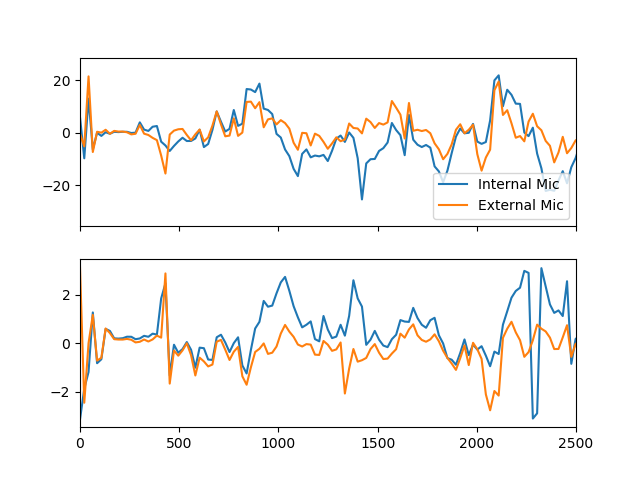

In [8]:
fig,ax = plt.subplots(2,sharex=True)

fig.set_label("Initial position (open) recordings, internal vs external spectra")

for acqresults in results:
    spectr_int = 20*np.log10(np.abs(acqresults[0]['int_mic']/refresult['int_mic']))
    angle_int = np.angle(acqresults[0]['int_mic']/refresult['int_mic'])
    ax[0].plot(refresult['int_ff'], spectr_int, label="Internal Mic")
    ax[1].plot(refresult['int_ff'], angle_int)
    
    spectr_ext = 20*np.log10(np.abs(acqresults[0]['ext_mic']/refresult['ext_mic']))
    angle_ext = np.angle(acqresults[0]['ext_mic']/refresult['ext_mic'])
    ax[0].plot(refresult['ext_ff'], spectr_ext, label="External Mic")
    ax[1].plot(refresult['ext_ff'], angle_ext)

    ax[0].legend(loc='lower right')
    ax[0].set_xlim((0, 2500))

<IPython.core.display.Javascript object>


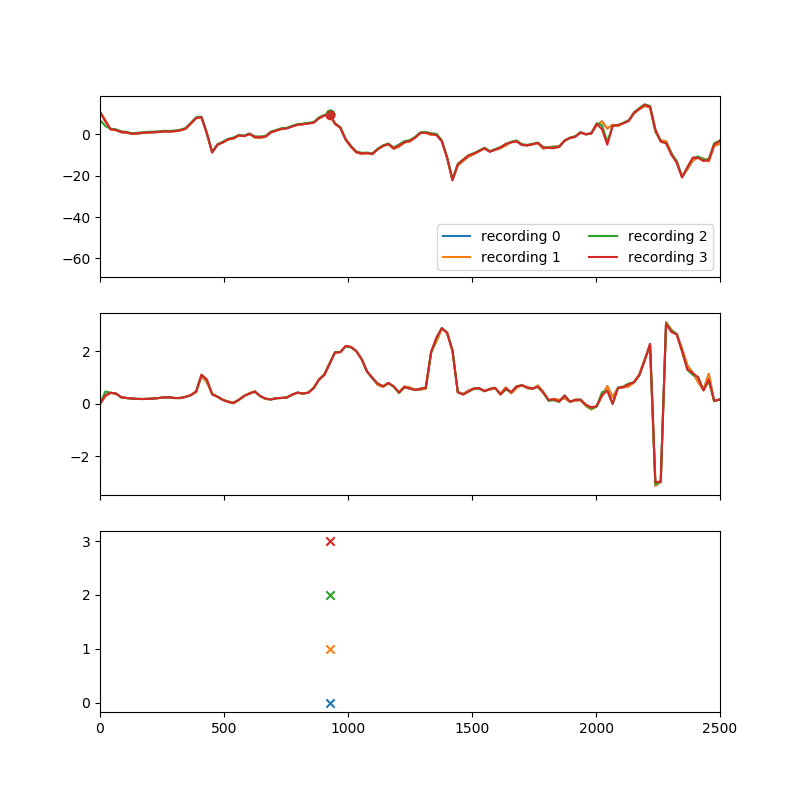

In [9]:
Hfy = []
Hfx = []
for acqno, acqresults in enumerate(results):
    Hfx.append([])
    Hfy.append([])
    fig,ax = plt.subplots(3,sharex=True, figsize=((8,8)))
    fig.set_label("Transfer functions, acquisition %d" % (acqno+1))
    
    for r in range(runs):
        ff = acqresults[r]['ext_ff']
        Hfreq = peakutils.indexes(
            (20*np.log10(np.abs(acqresults[r]['tf'])))[:100], thres=0.7, min_dist=1000)
        Hfx[acqno].extend(ff[Hfreq])
        Hfy[acqno].extend((20*np.log10(np.abs(acqresults[r]['tf'])))[Hfreq])
        
        ax[0].plot(ff, 20*np.log10(np.abs(acqresults[r]['tf'])), label="recording %d" % r)
        ax[0].scatter(Hfx[acqno][r], Hfy[acqno][r])
        ax[0].set_xlim((0, 2500))
        ax[0].legend(loc='lower right', ncol=2)
        
        ax[1].plot(ff,(np.angle(acqresults[r]['tf'])))
        ax[2].scatter(ff[Hfreq], r, marker='x')
#         ax[2].plot(ff, acqresults[r]['coh'])

In [17]:
effLincrs = []
inertvals = []
for acqno, acqresults in enumerate(results):
    inert = [gamma*P_a/(4*np.pi**2*f**2*V) for f in Hfx[acqno]]
    inertvals.append(inert)
    effL = [inert[i]*area/rho_a for i in range(runs)]
    effLincrs.append(effL)
    
print(inertvals)
print(np.mean(inertvals))

[[119.71747903186619, 119.71747903186619, 119.71747903186619, 119.71747903186619]]
119.717479032


In [23]:
Z_0 = rho_a*c/area
freqs = [c*n/(2*foot) for n in [1, 2, 4, 8]]
omega = [2*np.pi*f for f in freqs]
wL = [w*np.mean(inertvals) for w in omega]

<IPython.core.display.Javascript object>


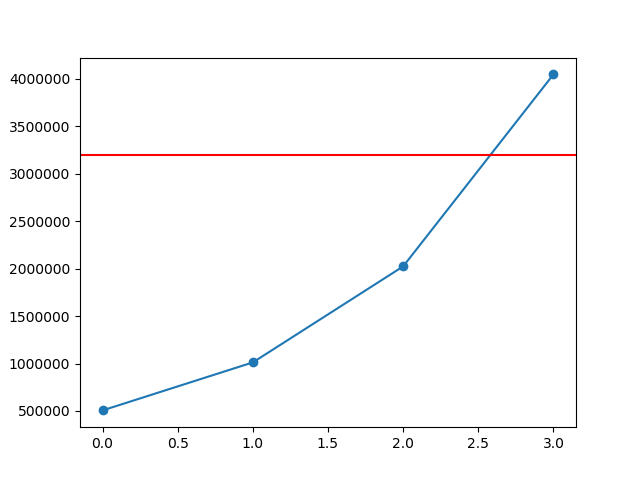

In [34]:
plt.figure()
plt.plot(wL, 'o-')
plt.axhline(Z_0, c='r')